**Fast and Easy Image-Based Coffee Plant Disease Detection Application**

# Import Library

In [1]:
# Visualization
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Dir manipulation
import os
from shutil import copyfile

# Model Machine Learning
import tensorflow as tf
  # Library Optimizer
from tensorflow.keras.optimizers import RMSprop
  # Libary Image preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Matrix Manipulation
import numpy as np

# Etc
import random

In [2]:
base_dir = "D:/hamzah/skripsi/Coffee Leaf Diseases/final_no_aug"
#Folder Train, Validation, and Testing
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
testing_dir = os.path.join(base_dir, 'testing')

# Directory with training  pictures
train_healthy_dir = os.path.join(train_dir, 'healthy')
train_miner_dir = os.path.join(train_dir, 'miner')
train_phoma_dir = os.path.join(train_dir, 'phoma')
train_rust_dir = os.path.join(train_dir, 'rust')

# Directory with validation pictures
validation_healthy_dir = os.path.join(validation_dir, 'healthy')
validation_miner_dir = os.path.join(validation_dir, 'miner')
validation_phoma_dir = os.path.join(validation_dir, 'phoma')
validation_rust_dir = os.path.join(validation_dir, 'rust')

# Directory with testing pictures
testing_healthy_dir = os.path.join(testing_dir, 'healthy')
testing_miner_dir = os.path.join(testing_dir, 'miner')
testing_phoma_dir = os.path.join(testing_dir, 'phoma')
testing_rust_dir = os.path.join(testing_dir, 'rust')

In [3]:
train_healthy_fnames = os.listdir( train_healthy_dir )
train_miner_fnames = os.listdir( train_miner_dir )
train_phoma_fnames = os.listdir( train_phoma_dir )
train_rust_fnames = os.listdir( train_rust_dir )

In [4]:
#Print Total Images
print('total training healthy images :', len(os.listdir(train_healthy_dir )))
print('total training miner images :', len(os.listdir(train_miner_dir )))
print('total training phoma images :', len(os.listdir(train_phoma_dir )))
print('total training rust images :', len(os.listdir(train_rust_dir )), "\n")

print('total validation healthy images :', len(os.listdir(validation_healthy_dir)))
print('total validation miner images :', len(os.listdir(validation_miner_dir)))
print('total validation phoma images :', len(os.listdir(validation_phoma_dir)))
print('total validation rust images :', len(os.listdir(validation_rust_dir)), "\n")

print('total testing healthy images :', len(os.listdir(testing_healthy_dir)))
print('total testing miner images :', len(os.listdir(testing_miner_dir)))
print('total testing phoma images :', len(os.listdir(testing_phoma_dir)))
print('total testing rust images :', len(os.listdir(testing_rust_dir)))

total training healthy images : 302
total training miner images : 362
total training phoma images : 386
total training rust images : 323 

total validation healthy images : 49
total validation miner images : 49
total validation phoma images : 49
total validation rust images : 49 

total testing healthy images : 49
total testing miner images : 49
total testing phoma images : 49
total testing rust images : 49


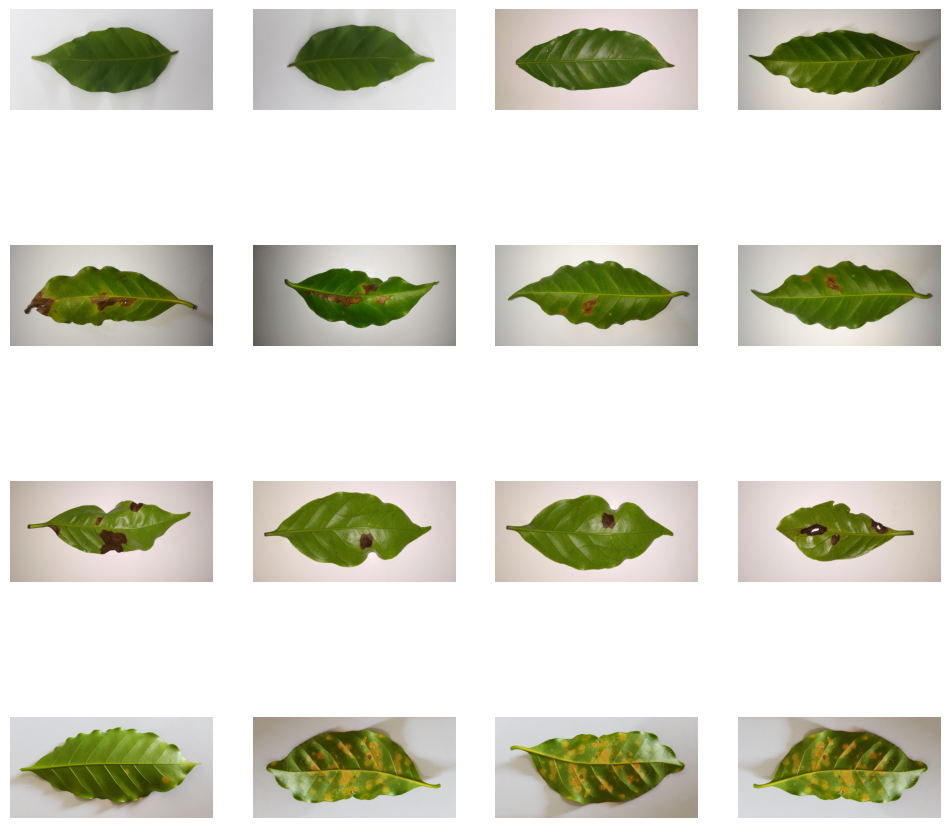

In [5]:
#Showing Sample Image each Class

%matplotlib inline

# Parameters for our graph; we'll output images in a 4x8 configuration
nrows = 8
ncols = 4

pic_index = 0 # Index for iterating over images

# Set up matplotlib fig, and size it to fit 4x8 pics
fig = plt.gcf()
fig.set_size_inches(ncols*3, nrows*3)

pic_index+=4

next_healthy_pix = [os.path.join(train_healthy_dir, fname)
                for fname in train_healthy_fnames[ pic_index-4:pic_index]
               ]

next_miner_pix = [os.path.join(train_miner_dir, fname)
                for fname in train_miner_fnames[ pic_index-4:pic_index]
               ]

next_phoma_pix = [os.path.join(train_phoma_dir, fname)
                for fname in train_phoma_fnames[ pic_index-4:pic_index]
               ]

next_rust_pix = [os.path.join(train_rust_dir, fname)
                for fname in train_rust_fnames[ pic_index-4:pic_index]
               ]

for i, img_path in enumerate(next_healthy_pix+next_miner_pix+next_phoma_pix+next_rust_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


# Data Preparation & Augmentation

In [6]:
# Apply data augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255, #normalization
      fill_mode='nearest'
      )

validation_datagen = ImageDataGenerator(rescale=1./255) #normalization

train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(256, 256),  # All images will be resized to 256 x 256
        batch_size=128,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,  # This is the source directory for training images
        target_size=(256, 256),  # All images will be resized to 150 x 150
        batch_size=32,
        class_mode='categorical')

Found 1373 images belonging to 4 classes.
Found 196 images belonging to 4 classes.


In [7]:
testing_generator = validation_datagen.flow_from_directory(
        testing_dir,  # This is the source directory for testing images
        target_size=(256, 256),  # Resize images to 256 x 256
        batch_size=25,
        class_mode='categorical',
        shuffle=False  # Disable shuffling for testing
)

Found 196 images belonging to 4 classes.


## VGG16 Architecture

### Architecture

In [8]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (256, 256, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

In [9]:
for layer in base_model.layers:
    layer.trainable = False

In [10]:
from tensorflow.keras.regularizers import l2

# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = tf.keras.layers.Dense(416, activation='relu', kernel_regularizer=l2(0.01))(x)

# Add a dropout rate of 0.5
x = tf.keras.layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = tf.keras.layers.Dense(4, activation='softmax')(x)

model_vgg = tf.keras.models.Model(base_model.input, x)

model_vgg.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=3.5481e-05),
              loss = 'categorical_crossentropy',
              metrics = ['acc'])


In [11]:
vgg_hist = model_vgg.fit(train_generator, validation_data = validation_generator, epochs = 2)


Epoch 1/2


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 122s 10s/step - acc: 0.3105 - loss: 9.9763 - val_acc: 0.5816 - val_loss: 8.9639
Epoch 2/2
11/11 ━━━━━━━━━━━━━━━━━━━━ 116s 10s/step - acc: 0.5523 - loss: 8.9075 - val_acc: 0.5306 - val_loss: 8.7058


In [12]:
model_vgg.evaluate(validation_generator)

7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - acc: 0.5190 - loss: 8.7174


[8.705821990966797, 0.5306122303009033]

# Hyperparameter Tunning

### Define Callback for Hyperparameter Tuning

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-5 * 10 ** (epoch / 20))

# ReduceLROnPlateau Callback: Mengurangi learning rate saat val_loss tidak membaik
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                                 patience=5, min_lr=1e-7)

# ModelCheckpoint Callback: Menyimpan model terbaik berdasarkan val_loss
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.keras', 
                                                monitor='val_loss', 
                                                save_best_only=True)

# EarlyStopping Callback: Menghentikan pelatihan jika tidak ada peningkatan val_loss setelah 3 epoch
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=5, 
                                                  restore_best_weights=True)

# Compile model with initial learning rate
model_vgg.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(learning_rate=1e-5),
                  metrics=['accuracy'])

# Training model with multiple callbacks
history = model_vgg.fit(train_generator, 
                        # epochs=50,  
                        epochs=2,  
                        validation_data=validation_generator, 
                        callbacks=[reduce_lr, checkpoint, early_stopping])

Epoch 1/2
11/11 ━━━━━━━━━━━━━━━━━━━━ 120s 10s/step - accuracy: 0.6056 - loss: 8.5878 - val_accuracy: 0.7347 - val_loss: 8.4307 - learning_rate: 1.0000e-05
Epoch 2/2
11/11 ━━━━━━━━━━━━━━━━━━━━ 117s 10s/step - accuracy: 0.6938 - loss: 8.4028 - val_accuracy: 0.7194 - val_loss: 8.3219 - learning_rate: 1.0000e-05


### Visualize Hyperparameter Performance

In [14]:
# Load model terbaik yang disimpan oleh ModelCheckpoint
best_model = tf.keras.models.load_model('best_model.keras')

# Evaluasi pada validation set atau testing set
loss, accuracy = best_model.evaluate(validation_generator)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7394 - loss: 8.3062
Validation Loss: 8.321859359741211
Validation Accuracy: 0.7193877696990967


#### Accuracy & loss plot

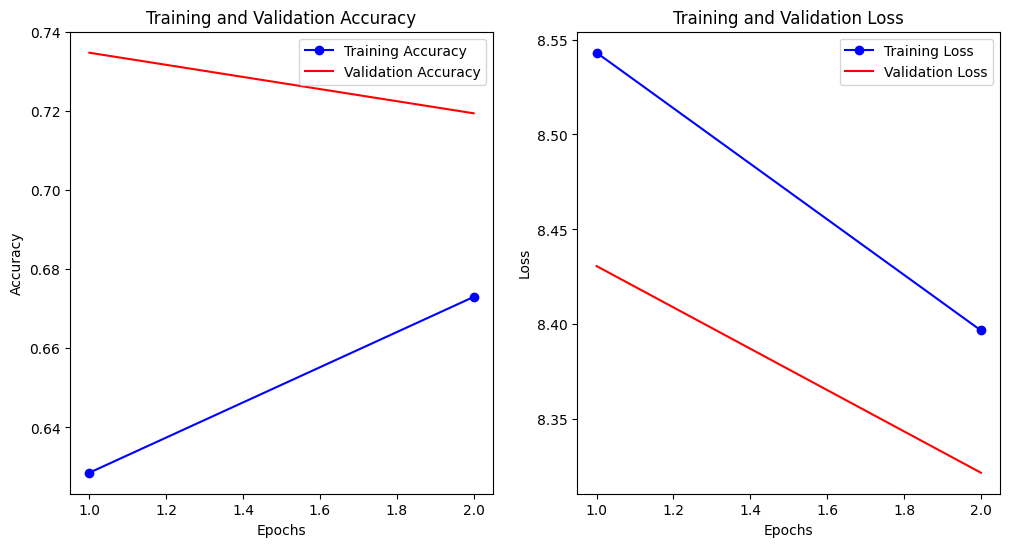

In [15]:

# Ambil nilai akurasi dan loss dari history training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)  # Jumlah epoch

# Plot Akurasi Training dan Validation
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss Training dan Validation
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluate Model

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Melakukan prediksi pada data validation
predictions = model_vgg.predict(validation_generator)

# Konversi prediksi probabilitas ke label kategori
y_pred = np.argmax(predictions, axis=1)

# Mendapatkan label aktual
y_true = validation_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification Report (Precision, Recall, F1-score, Accuracy)
print("Classification Report:")
print(classification_report(y_true, y_pred))


7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
Confusion Matrix:
[[15 12 13  9]
 [17 14 14  4]
 [26  7 13  3]
 [14 19 12  4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.31      0.25        49
           1       0.27      0.29      0.28        49
           2       0.25      0.27      0.26        49
           3       0.20      0.08      0.12        49

    accuracy                           0.23       196
   macro avg       0.23      0.23      0.22       196
weighted avg       0.23      0.23      0.22       196



c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step


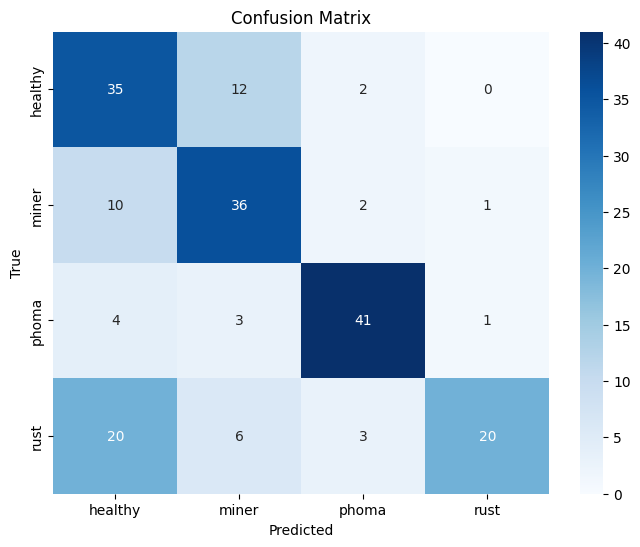

In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Melakukan prediksi pada data validation
predictions = model_vgg.predict(testing_generator)

# Konversi prediksi probabilitas ke label kategori
y_pred = np.argmax(predictions, axis=1)

# Mendapatkan label aktual
y_true = testing_generator.classes

# Menghitung confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualisasi confusion matrix menggunakan seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Fine-tuning

In [18]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import tensorflow as tf

# Load the VGG16 model
base_model = VGG16(input_shape=(256, 256, 3), include_top=False, weights='imagenet')

# Membekukan semua lapisan, kecuali lapisan terakhir (teratas)
for layer in base_model.layers[:-4]:  # Membuka 4 lapisan terakhir untuk fine-tuning
    layer.trainable = False

# Memeriksa status trainable lapisan model
for layer in base_model.layers:
    print(layer, layer.trainable)

<InputLayer name=input_layer_1, built=True> False
<Conv2D name=block1_conv1, built=True> False
<Conv2D name=block1_conv2, built=True> False
<MaxPooling2D name=block1_pool, built=True> False
<Conv2D name=block2_conv1, built=True> False
<Conv2D name=block2_conv2, built=True> False
<MaxPooling2D name=block2_pool, built=True> False
<Conv2D name=block3_conv1, built=True> False
<Conv2D name=block3_conv2, built=True> False
<Conv2D name=block3_conv3, built=True> False
<MaxPooling2D name=block3_pool, built=True> False
<Conv2D name=block4_conv1, built=True> False
<Conv2D name=block4_conv2, built=True> False
<Conv2D name=block4_conv3, built=True> False
<MaxPooling2D name=block4_pool, built=True> False
<Conv2D name=block5_conv1, built=True> True
<Conv2D name=block5_conv2, built=True> True
<Conv2D name=block5_conv3, built=True> True
<MaxPooling2D name=block5_pool, built=True> True


In [19]:
# Membuat lapisan custom di atas VGG16
x = layers.Flatten()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(4, activation='softmax')(x)  # 4 class classification

# Membuat model baru
model = models.Model(base_model.input, x)

# Kompilasi model
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
# Path to save the fine-tuned model
fine_tuned_model_path = 'best_finetuned_model_vgg16.keras'

In [21]:
# Callback untuk menyimpan model terbaik dengan ekstensi .h5
model_checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_loss', save_best_only=True, verbose=1)

# Callback untuk mengurangi learning rate jika val_loss tidak membaik
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)

# Callback untuk menghentikan training jika tidak ada perbaikan pada val_loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Melatih model dengan callbacks
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[reduce_lr, early_stopping, model_checkpoint]
)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.2904 - loss: 1.5781
Epoch 1: val_loss improved from inf to 1.15285, saving model to best_finetuned_model_vgg16.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 132s 11s/step - accuracy: 0.2932 - loss: 1.5703 - val_accuracy: 0.4541 - val_loss: 1.1529 - learning_rate: 1.0000e-05
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.4956 - loss: 1.1840
Epoch 2: val_loss improved from 1.15285 to 0.94047, saving model to best_finetuned_model_vgg16.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 128s 11s/step - accuracy: 0.4963 - loss: 1.1807 - val_accuracy: 0.6480 - val_loss: 0.9405 - learning_rate: 1.0000e-05
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.5920 - loss: 0.9689
Epoch 3: val_loss improved from 0.94047 to 0.81363, saving model to best_finetuned_model_vgg16.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 126s 11s/step - accuracy: 0.5931 - loss: 0.9668 - val_accuracy: 0.6786 - val_loss: 0.8136 - learning_rate: 1.0000e-05
Epoch 4/50
11/1

In [22]:
best_finetuned_model = tf.keras.models.load_model(fine_tuned_model_path)
val_loss, val_accuracy = best_finetuned_model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9467 - loss: 0.1610
Validation Loss: 0.17523729801177979
Validation Accuracy: 0.9387755393981934


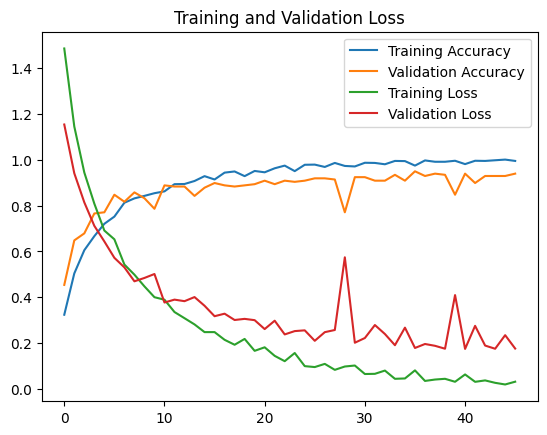

In [23]:
import matplotlib.pyplot as plt

# Plot akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step
Confusion Matrix:
[[47  2  0  0]
 [ 1 45  1  2]
 [ 2  1 46  0]
 [ 2  1  0 46]]
Classification Report:
              precision    recall  f1-score   support

     healthy       0.90      0.96      0.93        49
       miner       0.92      0.92      0.92        49
       phoma       0.98      0.94      0.96        49
        rust       0.96      0.94      0.95        49

    accuracy                           0.94       196
   macro avg       0.94      0.94      0.94       196
weighted avg       0.94      0.94      0.94       196



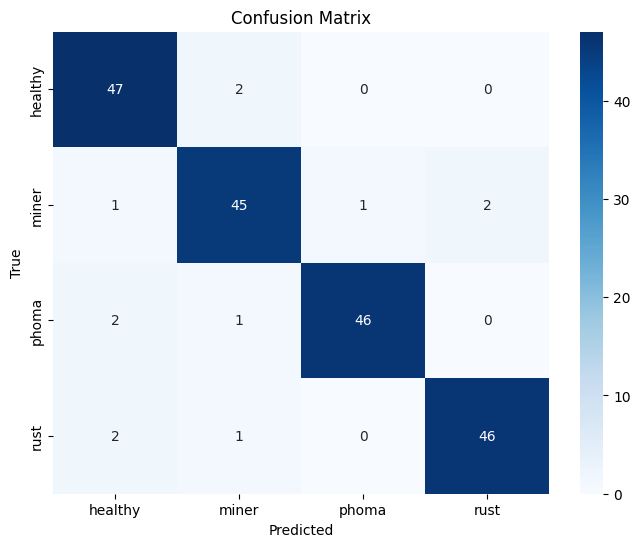

In [24]:
y_true = testing_generator.classes  # Label asli
y_pred = model.predict(testing_generator)  # Prediksi model
y_pred = np.argmax(y_pred, axis=1)

# Membuat confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
target_names = list(testing_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [25]:
test_loss, test_accuracy = model.evaluate(testing_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9397 - loss: 0.1780
Test Loss: 0.17035549879074097
Test Accuracy: 0.9387755393981934


# save model

In [30]:
model_vgg.save("D:/hamzah/skripsi/model/final_vgg16_no_aug.h5")

# Test Prediction

In [27]:
# import numpy as np
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from tensorflow.keras.models import load_model
# from PIL import Image, ImageDraw, ImageFont
# import os

# # Memuat model Keras .h5
# model = load_model("D:/hamzah/skripsi/model/final.h5")

# def predict_image(file_path):
#     # Memuat gambar asli untuk ditampilkan
#     img = Image.open(file_path)

#     # Memuat gambar dan mempersiapkannya untuk prediksi
#     img_resized = load_img(file_path, target_size=(256, 256))
#     x = img_to_array(img_resized)
#     x = np.expand_dims(x, axis=0) / 255.0  # Normalisasi jika model memerlukannya

#     # Melakukan prediksi menggunakan model Keras
#     predictions = model.predict(x)
#     prediction = np.argmax(predictions)

#     # Menentukan label berdasarkan hasil prediksi
#     labels = ["Healthy", "Miner", "Phoma", "Rust"]
#     result = labels[prediction]

#     # Menampilkan hasil prediksi di terminal
#     print(f"File yang diupload: {file_path}")
#     print(f"Hasil Prediksi: {result}")

#     # Menambahkan teks prediksi ke gambar menggunakan PIL
#     draw = ImageDraw.Draw(img)
    
#     # Cek apakah sistem memiliki font default atau menggunakan font bawaan
#     try:
#         font = ImageFont.truetype("arial.ttf", 36)  # Menggunakan Arial dengan ukuran 36
#     except IOError:
#         font = ImageFont.load_default()  # Fallback ke font default jika Arial tidak ditemukan

#     # Menambahkan teks pada gambar
#     text_position = (10, 10)
#     draw.text(text_position, f"Prediksi: {result}", font=font, fill=(255, 0, 0))  # Teks warna merah

#     # Menampilkan gambar dengan prediksi
#     img.show()

# if __name__ == "__main__":
#     # Input file path dari pengguna
#     file_path = input("Masukkan path file gambar: ")

#     if file_path and os.path.exists(file_path):
#         predict_image(file_path)
#     else:
#         print("Tidak ada file yang dipilih atau file tidak ditemukan.")


In [28]:
# contoh input
# D:/hamzah/skripsi/data untuk prediksi/healthy.jpg
# D:/hamzah/skripsi/data untuk prediksi/healthy2.jpg
# D:/hamzah/skripsi/data untuk prediksi/rust.jpg
# D:/hamzah/skripsi/data untuk prediksi/phoma.jpg
# D:/hamzah/skripsi/data untuk prediksi/miner.jpg

In [29]:
# from tensorflow.keras.preprocessing import image
# import numpy as np
# import os

# # Fungsi untuk memuat dan mempersiapkan gambar untuk prediksi
# def prepare_image(img_path):
#     img = image.load_img(img_path, target_size=(256, 256))  # Sesuaikan ukuran dengan model
#     img_array = image.img_to_array(img)  # Ubah ke array numpy
#     img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch
#     img_array /= 255.  # Normalisasi gambar seperti data training
#     return img_array

# # Dapatkan label kelas dari generator yang Anda gunakan (misalnya validation_generator)
# class_labels = list(validation_generator.class_indices.keys())

# # Path folder dengan gambar
# # folder_path = 'D:/hamzah/skripsi/dataset/rust'  # Ganti dengan folder yang berisi beberapa gambar
# folder_path = 'D:/hamzah/skripsi/dataset3/testing/healthy'  # Ganti dengan folder yang berisi beberapa gambar

# # Dictionary untuk menyimpan jumlah prediksi tiap kelas
# predictions_count = {label: 0 for label in class_labels}

# # Iterasi setiap gambar dalam folder
# for img_name in os.listdir(folder_path):
#     img_path = os.path.join(folder_path, img_name)
#     img_array = prepare_image(img_path)
    
#     # Lakukan prediksi
#     prediction = model.predict(img_array)
#     predicted_class = np.argmax(prediction, axis=1)
#     predicted_label = class_labels[predicted_class[0]]
    
#     # Tambahkan ke count untuk kelas yang diprediksi
#     predictions_count[predicted_label] += 1
    
#     print(f"Image {img_name} is predicted as: {predicted_label}")

# # Setelah iterasi, tampilkan total prediksi untuk setiap kelas
# print("\nTotal Predictions:")
# for label, count in predictions_count.items():
#     print(f"{label}: {count}")
